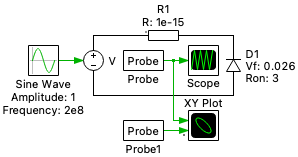

#### A simple, nonlinear circuit model
Originally implemented in PLECS. A resistor and a diode excited with a time harmonic signal (200 MHz).
This model determines the current drawn from the voltage source.

The goal is to use automatic differentiation to calculate $\partial i/\partial v$ which is needed
for the nonlinear Finite Element Method.

In [1]:
struct Dual{T <:Number} <:Number
     v::T
    dv::T
end

import Base: +, -, *, /
-(x::Dual)          = Dual(-x.v,       -x.dv)
+(x::Dual, y::Dual) = Dual( x.v + y.v,  x.dv + y.dv)
-(x::Dual, y::Dual) = Dual( x.v - y.v,  x.dv - y.dv)
*(x::Dual, y::Dual) = Dual( x.v * y.v,  x.dv * y.v + x.v * y.dv)
/(x::Dual, y::Dual) = Dual( x.v / y.v, (x.dv * y.v - x.v * y.dv)/y.v^2)

import Base: abs, sin, cos, tan, exp, log, sqrt, isless
abs(x::Dual)  = Dual(abs(x.v),sign(x.v)*x.dv)
sin(x::Dual)  = Dual(sin(x.v), cos(x.v)*x.dv)
cos(x::Dual)  = Dual(cos(x.v),-sin(x.v)*x.dv)
tan(x::Dual)  = Dual(tan(x.v), one(x.v)*x.dv + tan(x.v)^2*x.dv)
exp(x::Dual)  = Dual(exp(x.v), exp(x.v)*x.dv)
log(x::Dual)  = Dual(log(x.v), x.dv/x.v)
sqrt(x::Dual) = Dual(sqrt(x.v),.5/sqrt(x.v) * x.dv)
isless(x::Dual, y::Dual) = x.v < y.v;

import Base: convert, promote_rule
convert(::Type{Dual{T}}, x::Dual) where T = Dual(convert(T, x.v), convert(T, x.dv))
convert(::Type{Dual{T}}, x::Number) where T = Dual(convert(T, x), zero(T))
promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} = Dual{promote_type(T,R)}

import Base: show
show(io::IO, x::Dual) = print(io, "(", x.v, ") + [", x.dv, "ε]");
value(x::Dual) = x.v;
partials(x::Dual) = x.dv;

ε = Dual(0., 1.)

(0.0) + [1.0ε]

In [2]:
const T = Dual{Float64}

N = 2
M = 2

PM0_prevU = zeros(T, N)
PM0_u = zeros(T, N)
PM0_y = zeros(T, M)
PM0_topoIdx = 1
PM0_D_0_0 = [ 0.0 0.0
             -1.0 0.0]

function PM0_natPreComm_0() return 1 end
function PM0_natPostComm_0()
    global PM0_u
    u = PM0_u
    return (u[1] + u[2] < convert(T, 0)) ? 2 : 1
end

function PM0_forcedComm_0() return 1 end

PM0_D_0_1 = [-0.333333333333333204 -0.333333333333333204
             -0.999999999999999667  3.33333333333333261e-16]

function PM0_natPreComm_1() return 2 end
function PM0_natPostComm_1()
    global PM0_u
    u = PM0_u
    return (u[1] + u[2] >= convert(T, 0)) ? 1 : 2
end

function PM0_forcedComm_1() return 2 end

PM0_natPreComm  = Dict(1 => PM0_natPreComm_0,  2 => PM0_natPreComm_1)
PM0_natPostComm = Dict(1 => PM0_natPostComm_0, 2 => PM0_natPostComm_1)
PM0_forcedComm  = Dict(1 => PM0_forcedComm_0,  2 => PM0_forcedComm_1)
PM0_D_0 = Dict(1 => PM0_D_0_0, 2 => PM0_D_0_1)
PM0_topologies = [1, 2]

function diode_PM0_natComm()
    global PM0_topoIdx
    PM0_topoIdx = PM0_natPreComm[PM0_topoIdx]()
    PM0_topoIdx = PM0_natPostComm[PM0_topoIdx]()
end

function diode_PM0_forcedComm()
    global PM0_topoIdx
    PM0_topoIdx = PM0_forcedComm[PM0_topoIdx]();
end

function diode_PM0_output_0()
    global PM0_topoIdx
    global PM0_D_0
    global PM0_y
    global PM0_u
    
    meterIdx = [1, 2]
    PM0_y[meterIdx] .= PM0_D_0[PM0_topoIdx] * PM0_u
end

sampleTime = 1e-11

function diode_initialize()
    global PM0_topoIdx
    PM0_topoIdx = 1;
end

function diode_step!()
    global PM0_u
    global PM0_prevU
    
    diode_PM0_natComm()
    diode_PM0_forcedComm()
    diode_PM0_output_0()
       
    PM0_prevU .= PM0_u
end

diode_step! (generic function with 1 method)

In [3]:
diode_initialize()
t = range(0, 5e-9, step=sampleTime)
u = zeros(length(t), 2)
y = zeros(length(t), 2)
dydu = zeros(length(t))

for i=1:length(t)
    PM0_u[1] = 1.0sin(2π * 2e8 * t[i]) .+ ε
    PM0_u[2] = 0.026 # diode's treshold voltage
    diode_step!()
    u[i, :] .= value.(PM0_u)
    y[i, :] .= value.(PM0_y)
    dydu[i]  = partials(PM0_y[1])
end

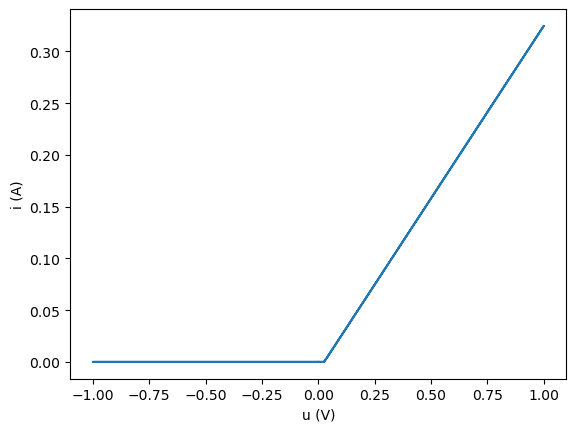

In [4]:
using PyPlot
plot(-u[:, 1], y[:, 1])
xlabel("u (V)")
ylabel("i (A)")
nothing

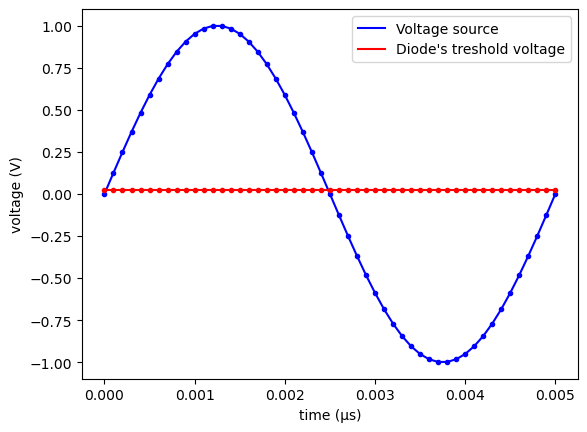

In [5]:
using DelimitedFiles
c = readdlm("out.csv", '\t') # gcc diode.c && ./a.out > out.csv

plot(1e6t[1:10:end], c[1:10:end, 1], "b-")
plot(1e6t[1:10:end], c[1:10:end, 2], "r-")
plot(1e6t[1:10:end], u[1:10:end, 1], "b.")
plot(1e6t[1:10:end], u[1:10:end, 2], "r.")
xlabel("time (μs)")
ylabel("voltage (V)")
legend(("Voltage source", "Diode's treshold voltage"));

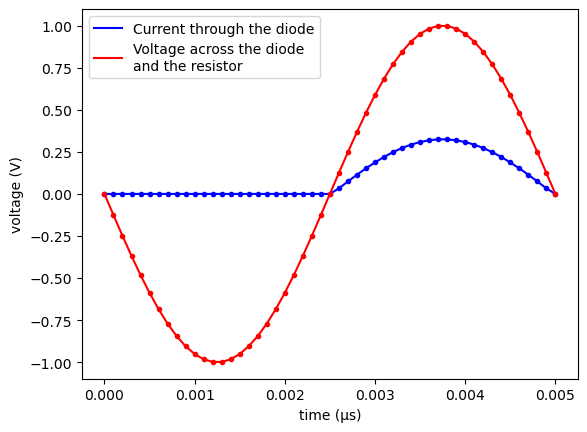

In [6]:
plot(1e6t[1:10:end], c[1:10:end, 3], "b-")
plot(1e6t[1:10:end], c[1:10:end, 4], "r-")
plot(1e6t[1:10:end], y[1:10:end, 1], "b.")
plot(1e6t[1:10:end], y[1:10:end, 2], "r.")
xlabel("time (μs)")
ylabel("voltage (V)")
legend(("Current through the diode", "Voltage across the diode\nand the resistor"));

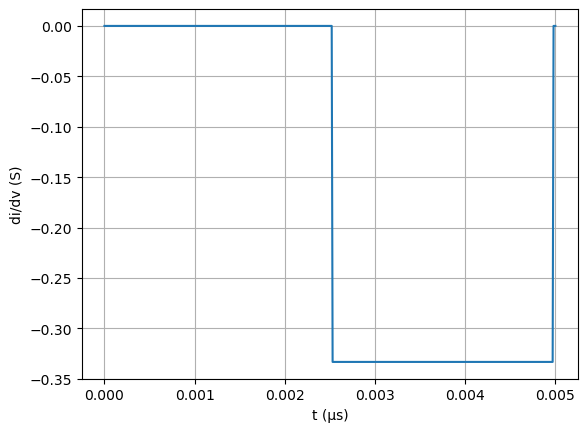

In [7]:
plot(1e6t, dydu)
xlabel("t (μs)")
ylabel("di/dv (S)")
grid();